<a href="https://colab.research.google.com/github/khalit7/Computer_Vision_Models_Analysis/blob/main/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=defc1621142ad432980b07274c7d38e6e30d83cca5fd8aaa96aa2818e16c89d3
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [2]:
import os
import math

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset,random_split

import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision.utils import make_grid
from torchsummary import summary
from sklearn.metrics import accuracy_score
from PIL import Image
#from torchviz import make_dot
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#Dataset

In [3]:
BATCH_SIZE=128

In [4]:
def visualize_data(data_loader,num_examples = BATCH_SIZE ):
  for images,labels in data_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break


## MNIST

In [5]:
MNIST_data =   torchvision.datasets.MNIST('.', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
MNIST_data_loader = torch.utils.data.DataLoader(MNIST_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
len(MNIST_data_loader)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



469

In [6]:
MNIST_classes = MNIST_data.classes
MNIST_classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([128, 1, 28, 28])


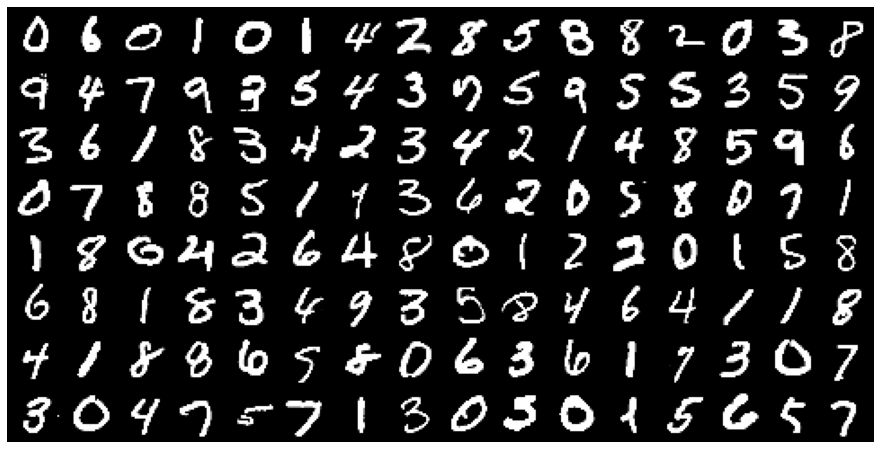

In [7]:
visualize_data(MNIST_data_loader)

## CIFAR

In [8]:
CIFAR_data =   torchvision.datasets.CIFAR10('.', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ]))
CIFAR_data_loader = torch.utils.data.DataLoader(CIFAR_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
print(len(CIFAR_data_loader))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
391


In [9]:
CIFAR_classes = CIFAR_data.classes
CIFAR_classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

images.shape: torch.Size([128, 3, 32, 32])


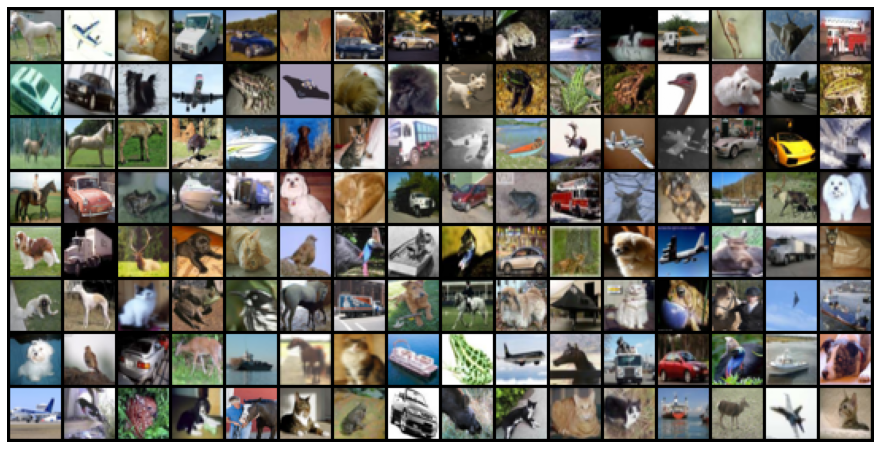

In [10]:
visualize_data(CIFAR_data_loader)

#Models

In [ ]:
# random input to test models if needed 
input = torch.rand(2,3,224,224).to(device)
print(input.dtype)
print(input.shape)

## VGG

## ResNet

In [11]:
resnet = models.resnet34(num_classes=10).to(device)

## GoogleNet

In [ ]:
googlenet = models.googlenet(num_classes= 10).to(device)

## Custom model

#Training and validation boilerplate

In [18]:
obj_func = nn.CrossEntropyLoss()

In [34]:
def training_step(model,optimizer,dataloader,is_googleNet):
  avg_loss=0
  correct_preds=0
  for batch_idx,(img,label) in enumerate(dataloader):
    img,label = img.to(device), label.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()

    #
    if is_googleNet:
      aux1,aux2,output = model(img)
      loss1 = obj_func(output,label)
      loss2 = obj_func(aux1,label)
      loss3 = obj_func(aux2,label)
      loss = loss1 + 0.3* (loss2 + loss3)
    else:
      output = model(img)
      loss = obj_func(output,label)
    
    #
    loss.backward()
    optimizer.step()

    # accumulate batch loss
    avg_loss+=loss
    # calculate number of correct predictions
    preds = torch.argmax(output,axis=1)
    correct_preds += torch.sum(preds==label)
  # calculate avg losses
  avg_loss /= len(dataloader.dataset)
  # clculate accuracy
  acc = correct_preds/len(dataloader.dataset)
  return avg_loss.cpu().detach(),acc.cpu()

In [20]:
def evaluate(model,dataloader,is_googleNet):
  loss = 0
  correct_preds = 0
  for batch_idx,(img,label) in enumerate(dataloader):
    img,label = img.to(device), label.to(device)
    
    with torch.no_grad():
      if is_googleNet:
        _,_,output = model(img)
      else:
        output = model(img)
    
    loss = obj_func(output,label)
    
    # accumulate bactch loss
    loss += obj_func(output,label)

    # calculate number of correct predictions
    preds = torch.argmax(output,axis=1)
    correct_preds += torch.sum(preds==label)
  
  # calculate average loss
  loss /= len(dataloader.dataset)
  # clculate accuracy
  acc = correct_preds/len(dataloader.dataset)
  return loss.cpu(),acc.cpu()

In [21]:
NUM_EPOCHS = 10
def train(model,optimizer,train_loader,val_loader,num_epochs=NUM_EPOCHS,save_path="./",evaluate_every_epoch = 1,is_googleNet=False):
    training_loss_history = []
    training_acc_history = []
    val_loss_history = []
    val_acc_history = []
    best_acc = 0
    print("Training starting ... ")
    print()
    for epoch in range(num_epochs):
      print("Epoch number {} --------------------------------------------------".format(epoch+1))
      train_loss,train_acc = training_step(model,optimizer,train_loader,is_googleNet)
      training_loss_history.append(train_loss)
      training_acc_history.append(train_acc)
      print(" Training Loss = {}, Training Accuracy = {:0.2%} ".format(train_loss,train_acc))
      #
      if ((epoch+1)%evaluate_every_epoch)==0:
        print("performing validation : ")
        val_loss,val_acc = evaluate(model,val_loader)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        print(" validation  loss = {}, validation accuracy = {:0.2%} ".format(val_loss,val_acc))
        #TODO: if best val model, save model
        if val_acc > best_acc:
          print("Saving best model so far")
          best_acc = val_acc
          # save model
          torch.save(model.state_dict(), save_path)

    return training_loss_history,training_acc_history,val_loss_history,val_acc_history

# Training and visualization

In [12]:
def plot_helper(title,**kwargs):
  for curve_name,history in kwargs.items():
    plt.plot(history,label=curve_name)
  plt.legend()
  plt.title(title)

In [13]:
base_path = "/content/drive/MyDrive/computer vision project/"

## ResNet Training

### Training on CIFAR

In [29]:
def get_CIFAR_resnet(batch_size = BATCH_SIZE):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])

  train_loader = torch.utils.data.DataLoader(
          torchvision.datasets.CIFAR10(root='.',download=True, train=True, transform=transforms.Compose([
              transforms.RandomHorizontalFlip(),
              transforms.RandomCrop(32, 4),
              transforms.ToTensor(),
              normalize,
          ])),
          batch_size=BATCH_SIZE, shuffle=True,)

  val_loader = torch.utils.data.DataLoader(
          torchvision.datasets.CIFAR10(root='.', download=True, train=False, transform=transforms.Compose([
              transforms.ToTensor(),
              normalize,
          ])),
          batch_size=BATCH_SIZE, shuffle=False,)
  
  return train_loader,val_loader
    
cifar_train,cifar_val = get_CIFAR_resnet(batch_size=400)

Files already downloaded and verified
Files already downloaded and verified


In [32]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out
resnet = ResNet9(3, 10).to(device)

In [33]:
# First we define the optimizer
optimizer = torch.optim.Adam(resnet.parameters(), lr=3e-4)
# select path to save best model 
save_path = base_path + "Resnet/best_CIFAR"
#
training_loss_history,training_acc_history,val_loss_history,val_acc_history = train(resnet,optimizer,cifar_train,cifar_val,num_epochs=20,save_path=save_path,evaluate_every_epoch=1)

Training starting ... 

Epoch number 1 --------------------------------------------------
 Training Loss = 0.00924986507743597, Training Accuracy = 57.99% 
performing validation : 
 validation  loss = 0.00691803777590394, validation accuracy = 68.97% 
Saving best model so far
Epoch number 2 --------------------------------------------------
 Training Loss = 0.005674073938280344, Training Accuracy = 74.69% 
performing validation : 
 validation  loss = 0.005304413847625256, validation accuracy = 76.29% 
Saving best model so far
Epoch number 3 --------------------------------------------------
 Training Loss = 0.004457876551896334, Training Accuracy = 80.37% 
performing validation : 
 validation  loss = 0.004467837978154421, validation accuracy = 80.62% 
Saving best model so far
Epoch number 4 --------------------------------------------------
 Training Loss = 0.0037512769922614098, Training Accuracy = 83.52% 
performing validation : 
 validation  loss = 0.004131455905735493, validation a

In [35]:
print(training_loss_history)
print(training_acc_history)
print(val_loss_history)
print(val_acc_history)
np.save(base_path + "Resnet/CIFAR_train_loss.npy",np.array(training_loss_history))
np.save(base_path + "Resnet/CIFAR_train_acc.npy",np.array(training_acc_history))
np.save(base_path + "Resnet/CIFAR_val_loss.npy",np.array(val_loss_history))
np.save(base_path + "Resnet/CIFAR_val_acc.npy",np.array(val_acc_history))

[tensor(0.0092), tensor(0.0057), tensor(0.0045), tensor(0.0038), tensor(0.0033), tensor(0.0029), tensor(0.0026), tensor(0.0024), tensor(0.0022), tensor(0.0019), tensor(0.0018), tensor(0.0016), tensor(0.0015), tensor(0.0014), tensor(0.0013), tensor(0.0012), tensor(0.0011), tensor(0.0010), tensor(0.0009), tensor(0.0009)]
[tensor(0.5799), tensor(0.7469), tensor(0.8037), tensor(0.8352), tensor(0.8553), tensor(0.8727), tensor(0.8851), tensor(0.8962), tensor(0.9057), tensor(0.9164), tensor(0.9224), tensor(0.9270), tensor(0.9326), tensor(0.9391), tensor(0.9430), tensor(0.9479), tensor(0.9542), tensor(0.9559), tensor(0.9617), tensor(0.9625)]
[tensor(0.0069), tensor(0.0053), tensor(0.0045), tensor(0.0041), tensor(0.0038), tensor(0.0036), tensor(0.0034), tensor(0.0034), tensor(0.0032), tensor(0.0029), tensor(0.0030), tensor(0.0030), tensor(0.0028), tensor(0.0028), tensor(0.0027), tensor(0.0026), tensor(0.0029), tensor(0.0027), tensor(0.0027), tensor(0.0028)]
[tensor(0.6897), tensor(0.7629), tens

#### CIFAR training Visualization

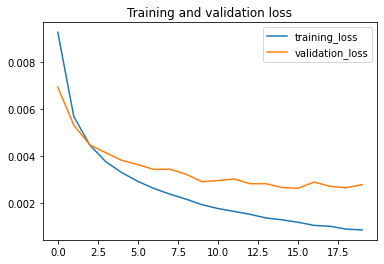

In [36]:
plot_helper("Training and validation loss",training_loss = training_loss_history,validation_loss = val_loss_history)

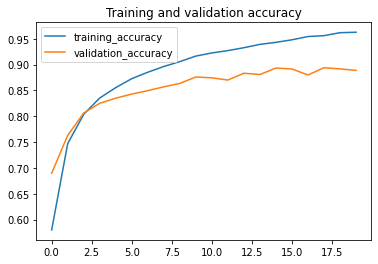

In [37]:
plot_helper("Training and validation accuracy",training_accuracy = training_acc_history,validation_accuracy = val_acc_history)

#### CIFAR predictions visualizations

### Training on MNIST

In [ ]:
def get_MNIST_resnet(batch_size = BATCH_SIZE):
    mnist = torchvision.datasets.MNIST(download=True, train=True, root=".").train_data.float()
    
    data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                         transforms.ToTensor(), 
                                         transforms.Normalize((mnist.mean()/255,), (mnist.std()/255,))])

    train_loader = DataLoader(torchvision.datasets.MNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=BATCH_SIZE, shuffle=True)

    val_loader = DataLoader(torchvision.datasets.MNIST(download=True, root=".", transform=data_transform, train=False),
                            batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, val_loader
    
mnist_train,mnist_val = get_MNIST_resnet()

In [ ]:
resnet = models.resnet34(num_classes=10).to(device)


In [ ]:
# tweek model slightly to work with MNIST (change the first convolution so it expects a gray scale image)
resnet.conv1 = torch.nn.Conv2d(1, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False).to(device)
# First we define the optimizer
optimizer = torch.optim.Adam(resnet.parameters(), lr=3e-4)
# select path to save best model 
save_path = base_path + "Resnet/best_MNIST"
#
training_loss_history,training_acc_history,val_loss_history,val_acc_history = train(resnet,optimizer,mnist_train,mnist_val,num_epochs=NUM_EPOCHS,save_path=save_path,evaluate_every_epoch=1)

Training starting ... 

Epoch number 1 --------------------------------------------------
 Training Loss = 0.0008365559624508023, Training Accuracy = 96.74% 
performing validation : 
 validation  loss = 0.0002590863441582769, validation accuracy = 99.02% 
Saving best model so far
Epoch number 2 --------------------------------------------------
 Training Loss = 0.00027115436387248337, Training Accuracy = 98.95% 
performing validation : 
 validation  loss = 0.00017633804236538708, validation accuracy = 99.26% 
Saving best model so far
Epoch number 3 --------------------------------------------------
 Training Loss = 0.00021532687242142856, Training Accuracy = 99.11% 
performing validation : 
 validation  loss = 0.00016875336586963385, validation accuracy = 99.31% 
Saving best model so far
Epoch number 4 --------------------------------------------------
 Training Loss = 0.00017521427071187645, Training Accuracy = 99.30% 
performing validation : 
 validation  loss = 0.0001608514867257326

In [ ]:
print(training_loss_history)
print(training_acc_history)
print(val_loss_history)
print(val_acc_history)
np.save(base_path + "Resnet/MNIST_train_loss.npy",np.array(training_loss_history))
np.save(base_path + "Resnet/MNIST_train_acc.npy",np.array(training_acc_history))
np.save(base_path + "Resnet/MNIST_val_loss.npy",np.array(val_loss_history))
np.save(base_path + "Resnet/MNIST_val_acc.npy",np.array(val_acc_history))

[tensor(0.0008, grad_fn=<ToCopyBackward0>), tensor(0.0003, grad_fn=<ToCopyBackward0>), tensor(0.0002, grad_fn=<ToCopyBackward0>), tensor(0.0002, grad_fn=<ToCopyBackward0>), tensor(0.0002, grad_fn=<ToCopyBackward0>), tensor(0.0001, grad_fn=<ToCopyBackward0>), tensor(0.0001, grad_fn=<ToCopyBackward0>), tensor(0.0001, grad_fn=<ToCopyBackward0>), tensor(9.7388e-05, grad_fn=<ToCopyBackward0>), tensor(8.5777e-05, grad_fn=<ToCopyBackward0>)]
[tensor(0.9674), tensor(0.9895), tensor(0.9911), tensor(0.9930), tensor(0.9941), tensor(0.9938), tensor(0.9945), tensor(0.9952), tensor(0.9961), tensor(0.9966)]
[tensor(0.0003), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0001), tensor(0.0002), tensor(0.0001), tensor(0.0002)]
[tensor(0.9902), tensor(0.9926), tensor(0.9931), tensor(0.9935), tensor(0.9942), tensor(0.9926), tensor(0.9938), tensor(0.9924), tensor(0.9948), tensor(0.9941)]


#### MNIST training Visualization

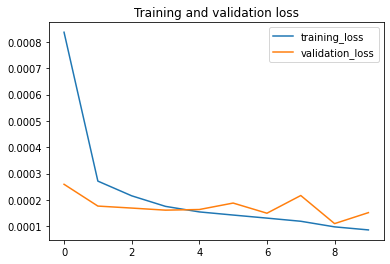

In [ ]:
plot_helper("Training and validation loss",training_loss = training_loss_history,validation_loss = val_loss_history)

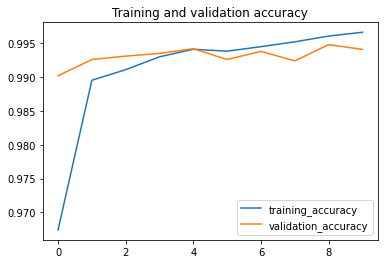

In [ ]:
plot_helper("Training and validation accuracy",training_accuracy = training_acc_history,validation_accuracy = val_acc_history)

#### MNIST predictions visualizations

## GoogleNet training